In [1]:
import os, sys, glob
import logging
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline

from signal_generator import SignalGenerator
from background_generator import BackgroundGenerator
from utils import bin_to_healpix, ang_dist

try:
    from tqdm.notebook import tqdm
except:
    def tqdm(x):
        for thing in x:
            print(".", end='\n')
            yield thing

# Instantiate the necessary objects

Here we need to actually load the information from the IceCube 10 year public dataset. I have this stored in my own folders, so you'll need to download it yourself from IceCube's webpage:

https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018/

Once you have it, unzip the file and put the correct path below as "public_data_directory". We use the information contained in the public data to calculate effective areas, livetime, and smearing effects from true parameters to reconstructed events.

In [2]:
public_data_directory = "../gxn/gXn_simulations/icecube_10year_ps/"

aeffs = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_effectiveArea.csv")))
smearing = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_smearing.csv")))
uptime = [os.path.join(public_data_directory, "uptime/IC86_II_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_III_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_IV_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_V_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VI_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VII_exp.csv")]
data = [os.path.join(public_data_directory, "events/IC86_II_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_III_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_IV_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_V_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VI_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VII_exp.csv")]

sigGen = SignalGenerator(aeffs, smearing, uptime,
                        angular_resolution_scale=1.0)
bgGen = BackgroundGenerator(data)


/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:91: RuntimeWarning: divide by zero encountered in log
  - np.cos(np.radians(smearing['AngErr_max[deg]'])))))


# Define your flux function.

We need a function here of the form 

    f(emin, emax) --> Phi (energy-integrated flux [1/cm2/s])
    
This function is used to calculate the total flux across each effective area bin. Once we have the energy-integrated flux, we calculate the expected events from each effective area bin

    N_{bin} = Aeff_{bin} * f(emin_{bin}, emax_{bin}) * livetime
    
which we can use to generate true event energies from your given spectrum. Note that additional parameters in `f(emin, emax)` are fine as long as they have default values.

In this particular example, we read fluxes from a provided csv file, interpolate, and integrate.

In [3]:
def integral_flux_from_file(emin, emax, 
                            energy_gev = None,
                            e2_flux = None,
                            source_csv = "nu_flux_q1.csv"):
    """
    Calculate the energy-integrated flux across an effective area bin in neutrino energy range [emin, emax]

    Args:
      emin: A Pandas Series containing minimum neutrino energies from the effective area
      emax: A Pandas Series containing maximum neutrino energies from the effective area
      energy_gev, e2_flux: The energy and E^2*flux you want to use for simulation. We do it this
            way so that we can explicitly choose the q and kappa we want to use.
        
    Returns:
      integrals: The energy-integrated flux across each given effective area bin.
    """
    # De-Pandasify, since UnivariateSpline.integral() doesn't like Pandas Series objects
    emin, emax = np.array(emin), np.array(emax)
    
    # Convert from E^2*flux to flux 
    f = e2_flux / energy_gev**2 

    # Spline (k=3) and integrate
    spline = UnivariateSpline(energy_gev, f)
        
    # And integrate to return
    integrals = [spline.integral(emin[_], emax[_]) for _ in range(len(emin))]
    return np.array(integrals)

# Generate signal events

Here we actually generate events from the position of CenA assuming the given model. The returned events are equivalent to what IceCube should expect to see, with true parameters (energy, direction) hidden and reconstructed parameters (energy proxy, best-fit direction, ect) provided.

In [11]:
# -----------------------------------------------
# Give the coordinates for CenA in degrees
# -----------------------------------------------
cena_dec_deg, cena_ra_deg = -43.0192, 201.3625

# -----------------------------------------------
# Set the number of trials and make the appropriate data structures
# -----------------------------------------------
ntrials_per = 100
distance_to_search = np.radians(1) 
results = {}

# -----------------------------------------------
# Run background-only trials at first.
# We'll store the result in results[(0,0)]
# where the (0,0) represents (q, kappa)
# -----------------------------------------------
kappa, q = 0, 0
results[(q, kappa)] = []
print('q={}, kappa={}'.format(0, 0))
for trial in tqdm(range(ntrials_per)):
    bg_events = bgGen.scramble()
    distances = ang_dist(np.radians(cena_ra_deg),
                         np.radians(cena_ra_deg),
                         bg_events['ra'], bg_events['dec'])
    results[(q, kappa)].append((distances < distance_to_search).sum())
    
# -----------------------------------------------
# Actually produce IceCube signal events from the 
# public data and your choice of model
# -----------------------------------------------
for q in [1, 2]:
    for index, kappa in enumerate([0.001, 0.01, 0.1]):
        print('q={}, kappa={}'.format(q, kappa))
        # -----------------------------------------------
        # Use a lambda for the flux now. This gives us more control over which flux we want
        # from the file when we run across multiple different fluxes.
        # -----------------------------------------------
        source_csv = "./cenA_fluxes/nu_flux_q{}.csv".format(q)
        values_csv = np.genfromtxt(source_csv, delimiter=',', skip_header=1).T
        energy_gev = values_csv[0]
        e2_flux = values_csv[index+1]
        integral_flux = lambda emin, emax: integral_flux_from_file(emin, emax, energy_gev, e2_flux)

        # -----------------------------------------------
        # Generate all of the trials that we want
        # -----------------------------------------------
        results[(q,kappa)] = []
        for trial in tqdm(range(ntrials_per)):
            sig_events = sigGen.generate_pointsource(declination_deg = cena_dec_deg, 
                                                    right_ascension_deg = cena_ra_deg,
                                                    integral_flux_function = integral_flux)
            bg_events = bgGen.scramble()
            events = pd.concat((sig_events, bg_events))
            distances = ang_dist(np.radians(cena_ra_deg),
                                 np.radians(cena_ra_deg),
                                 events['ra'], events['dec'])
            results[(q,kappa)].append((distances < distance_to_search).sum())

            
# -----------------------------------------------
# Convert results to numpy arrays
# -----------------------------------------------
for key in results.keys():
    results[key] = np.array(results[key])

q=0, kappa=0


  0%|          | 0/100 [00:00<?, ?it/s]

q=1, kappa=0.001


  0%|          | 0/100 [00:00<?, ?it/s]

q=1, kappa=0.01


  0%|          | 0/100 [00:00<?, ?it/s]

q=1, kappa=0.1


  0%|          | 0/100 [00:00<?, ?it/s]

q=2, kappa=0.001


  0%|          | 0/100 [00:00<?, ?it/s]

q=2, kappa=0.01


  0%|          | 0/100 [00:00<?, ?it/s]

q=2, kappa=0.1


  0%|          | 0/100 [00:00<?, ?it/s]

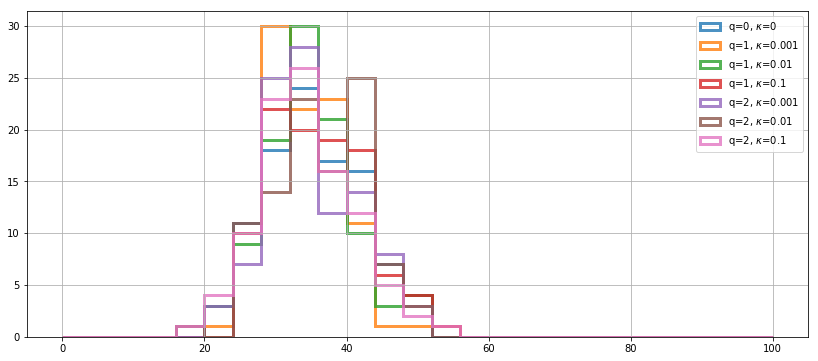

In [14]:
fig, ax = plt.subplots(figsize=(10,4))

bins = np.linspace(0, 100, 26)

for (q, kappa), counts in results.items():
    ax.hist(counts,
            bins=bins,
            histtype='step',
            linewidth=3,
            alpha=0.8,
            label = r'q={}, $\kappa$={}'.format(q, kappa))
ax.legend()
ax.grid()


# A mock-up of what we'd expect with higher kappas

Here I'm going to assume that I can just scale the flux up to approximate increasing kappa

In [54]:
# -----------------------------------------------
# Give the coordinates for CenA in degrees
# -----------------------------------------------
cena_dec_deg, cena_ra_deg = -43.0192, 201.3625

# -----------------------------------------------
# Set the number of trials and make the appropriate data structures
# -----------------------------------------------
ntrials_per = 100
distance_to_search = np.radians(1) 
results = {}

# -----------------------------------------------
# Run background-only trials at first.
# We'll store the result in results[(0,0)]
# where the (0,0) represents (q, kappa)
# -----------------------------------------------
kappa, q = 0, 0
results[(q, kappa)] = []
print('q={}, kappa={}'.format(0, 0))
for trial in tqdm(range(ntrials_per)):
    bg_events = bgGen.scramble()
    distances = ang_dist(np.radians(cena_ra_deg),
                         np.radians(cena_ra_deg),
                         bg_events['ra'], bg_events['dec'])
    results[(q, kappa)].append((distances < distance_to_search).sum())
    
# -----------------------------------------------
# Actually produce IceCube signal events from the 
# public data and your choice of model
# -----------------------------------------------
for q in [1, 2]:
    index = 1
    original_kappa = 0.01
    
    for kappa_scale in [1, 10, 100, 1000]:
        kappa = original_kappa * kappa_scale
        print('q={}, kappa={}'.format(q, kappa))
        # -----------------------------------------------
        # Use a lambda for the flux now. This gives us more control over which flux we want
        # from the file when we run across multiple different fluxes.
        # -----------------------------------------------
        source_csv = "./cenA_fluxes/nu_flux_q{}.csv".format(q)
        values_csv = np.genfromtxt(source_csv, delimiter=',', skip_header=1).T
        energy_gev = values_csv[0]
        e2_flux = values_csv[index+1] * kappa_scale
        integral_flux = lambda emin, emax: integral_flux_from_file(emin, emax, energy_gev, e2_flux)

        # -----------------------------------------------
        # Generate all of the trials that we want
        # -----------------------------------------------
        results[(q,kappa)] = []
        for trial in tqdm(range(ntrials_per)):
            sig_events = sigGen.generate_pointsource(declination_deg = cena_dec_deg, 
                                                    right_ascension_deg = cena_ra_deg,
                                                    integral_flux_function = integral_flux)
            bg_events = bgGen.scramble()
            events = pd.concat((sig_events, bg_events))

            sig_events['ra'] %= 2*np.pi
            ra, dec = sig_events['ra'], sig_events['dec']
            
            distances = ang_dist(np.radians(cena_ra_deg),
                                 np.radians(cena_dec_deg),
                                 events['ra'], events['dec'])
            results[(q,kappa)].append((distances < distance_to_search).sum())

# -----------------------------------------------
# Convert results to numpy arrays
# -----------------------------------------------
for key in results.keys():
    results[key] = np.array(results[key])

q=0, kappa=0


  0%|          | 0/100 [00:00<?, ?it/s]

q=1, kappa=0.01


  0%|          | 0/100 [00:00<?, ?it/s]

q=1, kappa=0.1


  0%|          | 0/100 [00:00<?, ?it/s]

q=1, kappa=1.0


  0%|          | 0/100 [00:00<?, ?it/s]

q=1, kappa=10.0


  0%|          | 0/100 [00:00<?, ?it/s]

q=2, kappa=0.01


  0%|          | 0/100 [00:00<?, ?it/s]

q=2, kappa=0.1


  0%|          | 0/100 [00:00<?, ?it/s]

q=2, kappa=1.0


  0%|          | 0/100 [00:00<?, ?it/s]

q=2, kappa=10.0


  0%|          | 0/100 [00:00<?, ?it/s]

In [55]:
for key in results:
    print(key, results[key].mean())

(0, 0) 35.47
(1, 0.01) 53.99
(1, 0.1) 212.6
(1, 1.0) 1833.35
(1, 10.0) 17965.31
(2, 0.01) 35.47
(2, 0.1) 36.04
(2, 1.0) 39.64
(2, 10.0) 72.22


Text(0,0.5,'Number of trials')

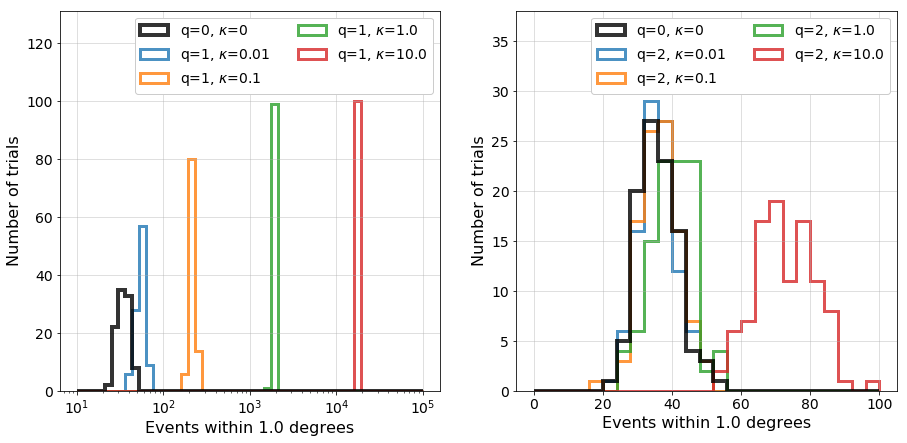

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

bins_q1 = np.logspace(1, 5, 51)
bins_q2 = np.linspace(0, 100, 26)

# --------------------------------------------
# Plot background-only cases for q=1 and q=2
# --------------------------------------------
background = results[(0,0)]
ax1.hist(background,
         bins=bins_q1,
         histtype='step',
         linewidth=4,
         color='k',
         alpha=0.8,
         label=r'q=0, $\kappa$=0',
         zorder=100,)
ax2.hist(background,
         bins=bins_q2,
         histtype='step',
         linewidth=4,
         color='k',
         alpha=0.8,
         label=r'q=0, $\kappa$=0',
         zorder=100,)

# --------------------------------------------
# And now plot the actual signal+background trials
# --------------------------------------------
for (q, kappa), counts in results.items():
    if q==1: 
        ax=ax1
        bins=bins_q1
    elif q==2: 
        ax=ax2
        bins=bins_q2
    else: continue
        
    ax.hist(counts,
            bins=bins,
            histtype='step',
            linewidth=3,
            alpha=0.8,
            label = r'q={}, $\kappa$={}'.format(q, kappa))

# --------------------------------------------
# Clean up the plots
# --------------------------------------------
ax1.legend(ncol=2, fontsize=14, framealpha=1)
ax1.grid(alpha=0.5)
ax1.tick_params(labelsize=14)
ax1.set_xscale('log')
ax1.set_ylim(ymax=ax1.set_ylim()[1]*1.25)
ax1.set_xlabel("Events within {} degrees".format(np.degrees(distance_to_search)), fontsize=16)
ax1.set_ylabel("Number of trials", fontsize=16)

ax2.legend(ncol=2, fontsize=14, framealpha=1)
ax2.grid(alpha=0.5)
ax2.tick_params(labelsize=14)
ax2.set_ylim(ymax=ax2.set_ylim()[1]*1.25)
ax2.set_xlabel("Events within {} degrees".format(np.degrees(distance_to_search)), fontsize=16)
ax2.set_ylabel("Number of trials", fontsize=16)
